# 라이브러리 로드

In [1]:
# 기초 전처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
import os

import warnings
warnings.filterwarnings(action = 'ignore')

# pandas 결과값의 표현 범위 소수점 2자리수로 변경
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 10000)

# 필요함수 정의

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def get_Standard(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_MinMaxScaler(df_x):
    m_scaler = MinMaxScaler()
    return m_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_Stan_log1p(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x.agg(np.log1p)).reshape(-1, 1)) 

def get_log1p(df_x):
    return df_x.agg(np.log1p)

In [3]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [4]:
def visualize_silhouette_scatter(cluster_lists, X_features):
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    
    markers=['o', 's', '^', 'P', 'D', 'H', 'x', '1','2', '3', '4','.',',','>','<','8','|','_']
    fig, axs = plt.subplots(figsize=(18, 4), nrows=1, ncols=len(cluster_lists))
    
    pca = PCA(n_components=2)
    X_trans = pca.fit_transform(X_features)
    cluster_df = pd.DataFrame()
    cluster_df['ftr1'] = X_trans[:,0]
    cluster_df['ftr2'] = X_trans[:,1]
    
    
    for pos, cluster in enumerate(cluster_lists):
#         cluster_df = pd.DataFrame(data=X_features_trans[:,:2], columns=['ftr1', 'ftr2'])
        kmeans = KMeans(n_clusters=cluster, init='k-means++', max_iter=500, random_state=0)
        cluster_labels = kmeans.fit_predict(X_features)
        cluster_df['kmeans_label'] = cluster_labels
        centers = kmeans.cluster_centers_
        unique_labels = np.unique(cluster_labels)
        
        for label in unique_labels:
            # 각각의 label 별 구분
            label_cluster = cluster_df[cluster_df['kmeans_label']==label]
            center_x_y = centers[label]

            # 구분 점 표시
            axs[pos].scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolors='k',
                        marker=markers[label])

#             # 중심 위치 좌표 시각화
#             axs[pos].scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white',
#                         alpha=0.9, edgecolors='k', marker=markers[label])
#             axs[pos].scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',
#                         edgecolors='k', marker='$%d$'%label)
            
        axs[pos].set_xlabel('ftr1')
        axs[pos].set_ylabel('ftr2')
        axs[pos].set_title('Number of Cluster: {}'.format(cluster))

    plt.show()

# Data load

In [5]:
df_i1 = pd.read_csv('./data/indicator/indicator_i1.csv')
df_i2 = pd.read_csv('./data/indicator/indicator_i2.csv')
df_i3 = pd.read_csv('./data/indicator/indicator_i3.csv')

df_final = pd.merge(df_i1, df_i2, on='상권_코드')
df_final = pd.merge(df_final, df_i3, on='상권_코드')
print(df_final.shape)
df_final = df_final.set_index('상권_코드')
df_final.head()

(1009, 4)


,i1_ind1,i2_ind1,i3_ind1
상권_코드,,,
1000001,0.11,0.37,0.33
1000002,0.16,0.34,0.24
1000003,0.07,0.42,0.61
1000004,0.25,0.34,0.39
1000005,0.07,0.15,0.59


# MeanShift 클러스터링

In [6]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

X = df_final
bandwidth = estimate_bandwidth(X)
meanshift = MeanShift(bandwidth=bandwidth)
cluster_labels = meanshift.fit_predict(X)
np.unique(cluster_labels)

array([0, 1, 2, 3, 4], dtype=int64)

In [7]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
    
pca = PCA(n_components=2)
X_trans = pca.fit_transform(X.iloc[:,:-1])
cluster_df = pd.DataFrame()
cluster_df['ftr1'] = X_trans[:,0]
cluster_df['ftr2'] = X_trans[:,1]
    
unique_labels = np.unique(cluster_labels)
cluster_df['meanshift_label']=cluster_labels
centers = meanshift.cluster_centers_
cluster_df.head()

,ftr1,ftr2,meanshift_label
0,0.02,-0.05,0
1,0.02,0.01,0
2,0.05,-0.10,0
3,0.05,0.09,0
4,-0.20,0.00,0


In [8]:
cluster_df.groupby('meanshift_label').size()

meanshift_label
0    958
1     23
2      1
3     17
4     10
dtype: int64

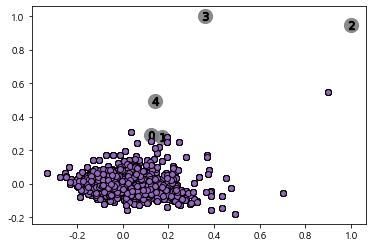

In [9]:
for label in unique_labels:
    label_cluster = cluster_df[cluster_df['meanshift_label']==cluster_labels]
    center_x_y = centers[label]
    # 군집별로 다른 마커로 산점도 적용

    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], 
                edgecolor='k')
    
    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9)
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', marker='$%d$' % label)
    
plt.show()

# KMeans 클러스터링

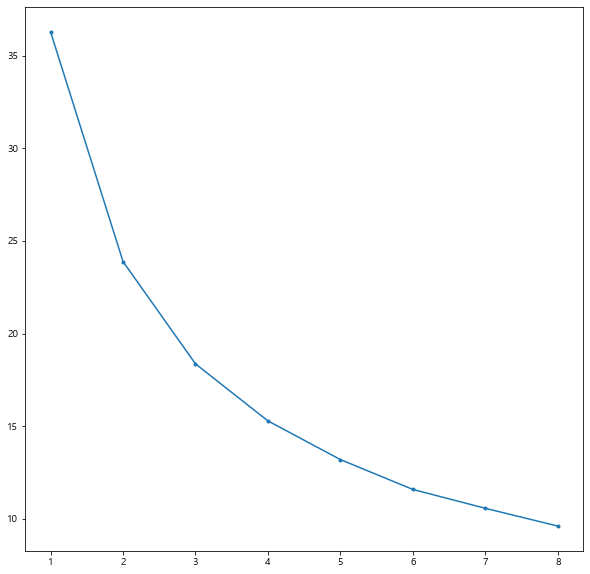

In [10]:
from sklearn.cluster import KMeans

sse = []
for i in range(1, 9):
    kmeans = KMeans(n_clusters=i, max_iter=300)
    kmeans.fit(df_final)
    sse.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 10))
plt.plot(range(1, 9), sse, marker='.')
plt.show()

KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=10), k=None)

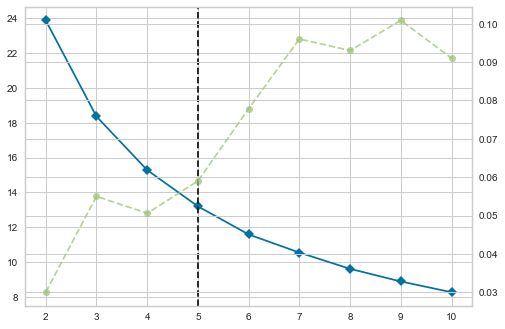

In [11]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()
model.fit(df_final)
visualizer = KElbowVisualizer(model)
visualizer.fit(df_final)

# 실루엣 계수 검정

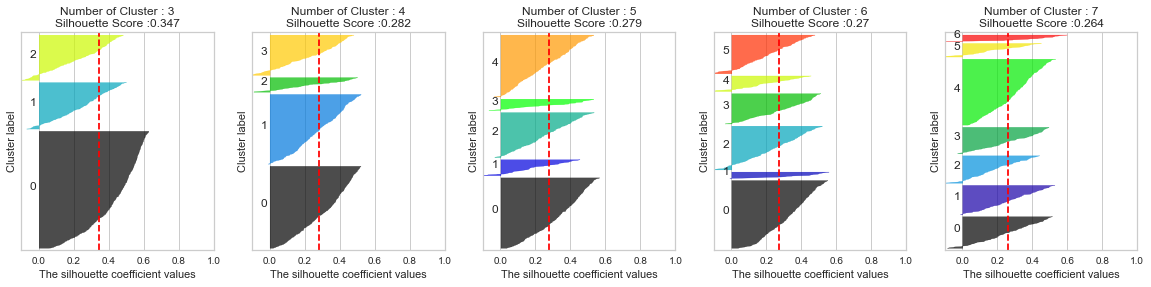

In [12]:
visualize_silhouette([3, 4, 5, 6, 7], df_final)

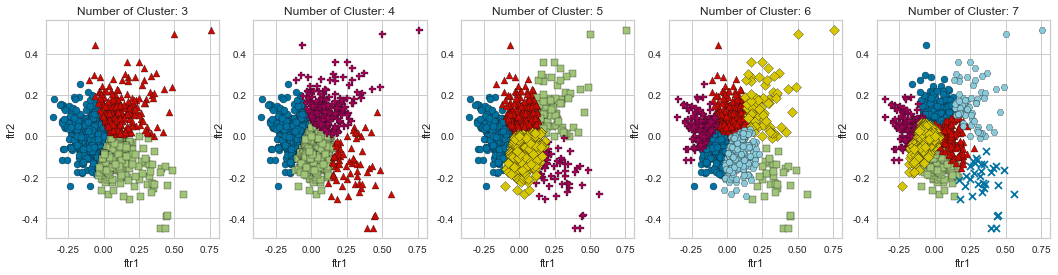

In [13]:
visualize_silhouette_scatter([3, 4, 5, 6, 7], df_final)

# 시각화

In [14]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=500, random_state=0)
kmeans.fit(df_final)
df_result = df_final
df_result['cluster_y'] = kmeans.labels_
df_final['cluster_y'] = kmeans.labels_

In [15]:
상권 = gpd.read_file('./data/geo/상권_geometry_좌표.geojson')
상권 = 상권[상권['TRDAR_SE_C']=='A']
상권['TRDAR_CD'] = 상권['TRDAR_CD'].astype(int)
상권.head(1)

,TRDAR_SE_C,TRDAR_SE_1,TRDAR_CD,TRDAR_CD_N,XCNTS_VALU,YDNTS_VALU,SIGNGU_CD,ADSTRD_CD,STDR_YM_CD,area,perimeter,x,y,geometry
70,A,골목상권,1000334,삼양로93길,201388,459892,11305,11305660,201810,78521.02,2144.94,127.02,37.64,"MULTIPOLYGON (((127.01677 37.63977, 127.01682 ..."


In [16]:
df_result = pd.merge(df_result, 상권, how='left', left_on='상권_코드', right_on='TRDAR_CD' )
df_result.head()

,i1_ind1,i2_ind1,i3_ind1,cluster_y,TRDAR_SE_C,TRDAR_SE_1,TRDAR_CD,TRDAR_CD_N,XCNTS_VALU,YDNTS_VALU,SIGNGU_CD,ADSTRD_CD,STDR_YM_CD,area,perimeter,x,y,geometry
0,0.11,0.37,0.33,2,A,골목상권,1000001,계동길,198799,453610,11110,11110600,201810,125350.78,2312.70,126.99,37.58,"MULTIPOLYGON (((126.98591 37.58549, 126.98626 ..."
1,0.16,0.34,0.24,2,A,골목상권,1000002,난계로27길,201996,452630,11110,11110710,201810,31696.16,959.67,127.02,37.57,"MULTIPOLYGON (((127.02335 37.57240, 127.02335 ..."
2,0.07,0.42,0.61,3,A,골목상권,1000003,돈화문로11가길,198977,452902,11110,11110615,201810,113805.69,1346.57,126.99,37.58,"MULTIPOLYGON (((126.98909 37.57418, 126.98771 ..."
3,0.25,0.34,0.39,2,A,골목상권,1000004,명륜길,199558,454351,11110,11110650,201810,44023.15,1384.35,126.99,37.59,"MULTIPOLYGON (((126.99403 37.59000, 126.99419 ..."
4,0.07,0.15,0.59,4,A,골목상권,1000005,백석동길,197153,455283,11110,11110550,201810,367064.09,4821.13,126.97,37.60,"MULTIPOLYGON (((126.97014 37.59995, 126.97301 ..."


In [17]:
df = df_final.groupby('cluster_y').mean()
df

,i1_ind1,i2_ind1,i3_ind1
cluster_y,,,
0,0.11,0.25,0.28
1,0.24,0.59,0.47
2,0.17,0.42,0.32
3,0.19,0.36,0.70
4,0.14,0.29,0.45


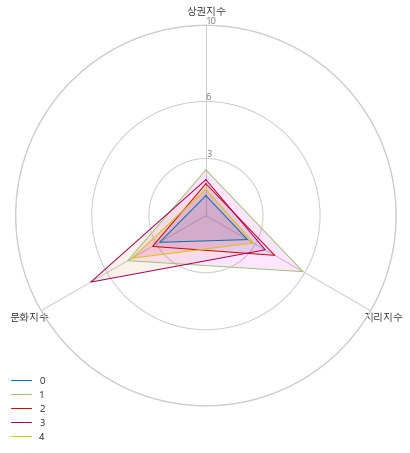

In [18]:
plt.rcParams['font.family'] = 'Malgun Gothic'
# categories = list(df)[0:]
categories = ['상권지수', '지리지수', '문화지수']
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(12, 7))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
plt.xticks(angles[:-1], categories)
plt.yticks([0.3, 0.6, 1.], ["3", "6", "10"], color='gray', size=10)
plt.ylim(0, 1.)

for idx, col in enumerate(['b','#FF00FF','#3333FF','peru','r']):
    values = df.loc[idx].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=idx)
    ax.fill(angles, values, col, alpha=0.1)

plt.legend(bbox_to_anchor=(0.1, 0.1), loc='best');

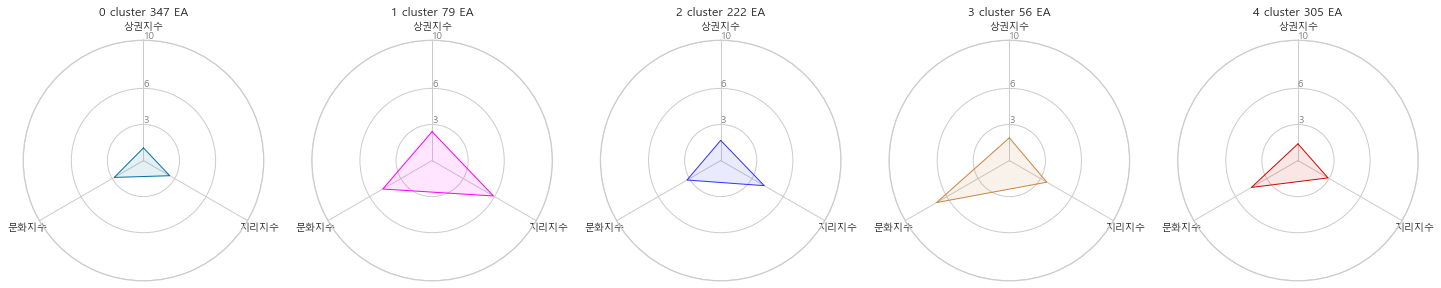

In [19]:
legend= df_final.groupby('cluster_y').size()

plt.rcParams['font.family'] = 'Malgun Gothic'
categories = ['상권지수', '지리지수', '문화지수']
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(1, 5, figsize=(25, 25))


for idx, col in enumerate(['b','#FF00FF','#3333FF','peru','r']):
    
    ax[idx] = plt.subplot( int(str(15)+str(idx+1)) , polar=True)
    
    ax[idx].set_theta_offset(np.pi / 2)
    ax[idx].set_theta_direction(-1)
    ax[idx].set_rlabel_position(0)
    
    ax[idx].set_xticks(angles[:-1])
    ax[idx].set_xticklabels(categories)
    ax[idx].set_yticks([0.3, 0.6, 1.])
    ax[idx].set_yticklabels(["3", "6", "10"], color='grey')
    
    ax[idx].set_ylim(0, 1.)
    ax[idx].set_title('{} cluster {} EA'.format(idx, legend.iloc[idx]))
    
    values = df.loc[idx].values.flatten().tolist()
    values += values[:1]
    
    ax[idx].plot(angles, values, color=col,linewidth=1, linestyle='solid', label=idx)
    ax[idx].fill(angles, values, facecolor=col, alpha=0.1)


In [43]:
df_result['cluster_y'] = df_result['cluster_y'].agg(lambda x : str(x))
gdf = gpd.GeoDataFrame(df_result, geometry='geometry')
gdf.head()

,i1_ind1,i2_ind1,i3_ind1,cluster_y,TRDAR_SE_C,TRDAR_SE_1,상권_코드,상권_도로_명,XCNTS_VALU,YDNTS_VALU,SIGNGU_CD,ADSTRD_CD,STDR_YM_CD,area,perimeter,x,y,geometry
0,0.11,0.37,0.33,2,A,골목상권,1000001,계동길,198799,453610,11110,11110600,201810,125350.78,2312.70,126.99,37.58,"MULTIPOLYGON (((126.98591 37.58549, 126.98626 ..."
1,0.16,0.34,0.24,2,A,골목상권,1000002,난계로27길,201996,452630,11110,11110710,201810,31696.16,959.67,127.02,37.57,"MULTIPOLYGON (((127.02335 37.57240, 127.02335 ..."
2,0.07,0.42,0.61,3,A,골목상권,1000003,돈화문로11가길,198977,452902,11110,11110615,201810,113805.69,1346.57,126.99,37.58,"MULTIPOLYGON (((126.98909 37.57418, 126.98771 ..."
3,0.25,0.34,0.39,2,A,골목상권,1000004,명륜길,199558,454351,11110,11110650,201810,44023.15,1384.35,126.99,37.59,"MULTIPOLYGON (((126.99403 37.59000, 126.99419 ..."
4,0.07,0.15,0.59,4,A,골목상권,1000005,백석동길,197153,455283,11110,11110550,201810,367064.09,4821.13,126.97,37.60,"MULTIPOLYGON (((126.97014 37.59995, 126.97301 ..."


In [44]:
url='https://raw.githubusercontent.com/suanlab/dataset/master'
seoul_geo = f'{url}/seoul_municipalities_geo_simple.json'
seoul_lay = gpd.read_file(seoul_geo)
seoul_lay = seoul_lay.to_crs(gdf.crs)

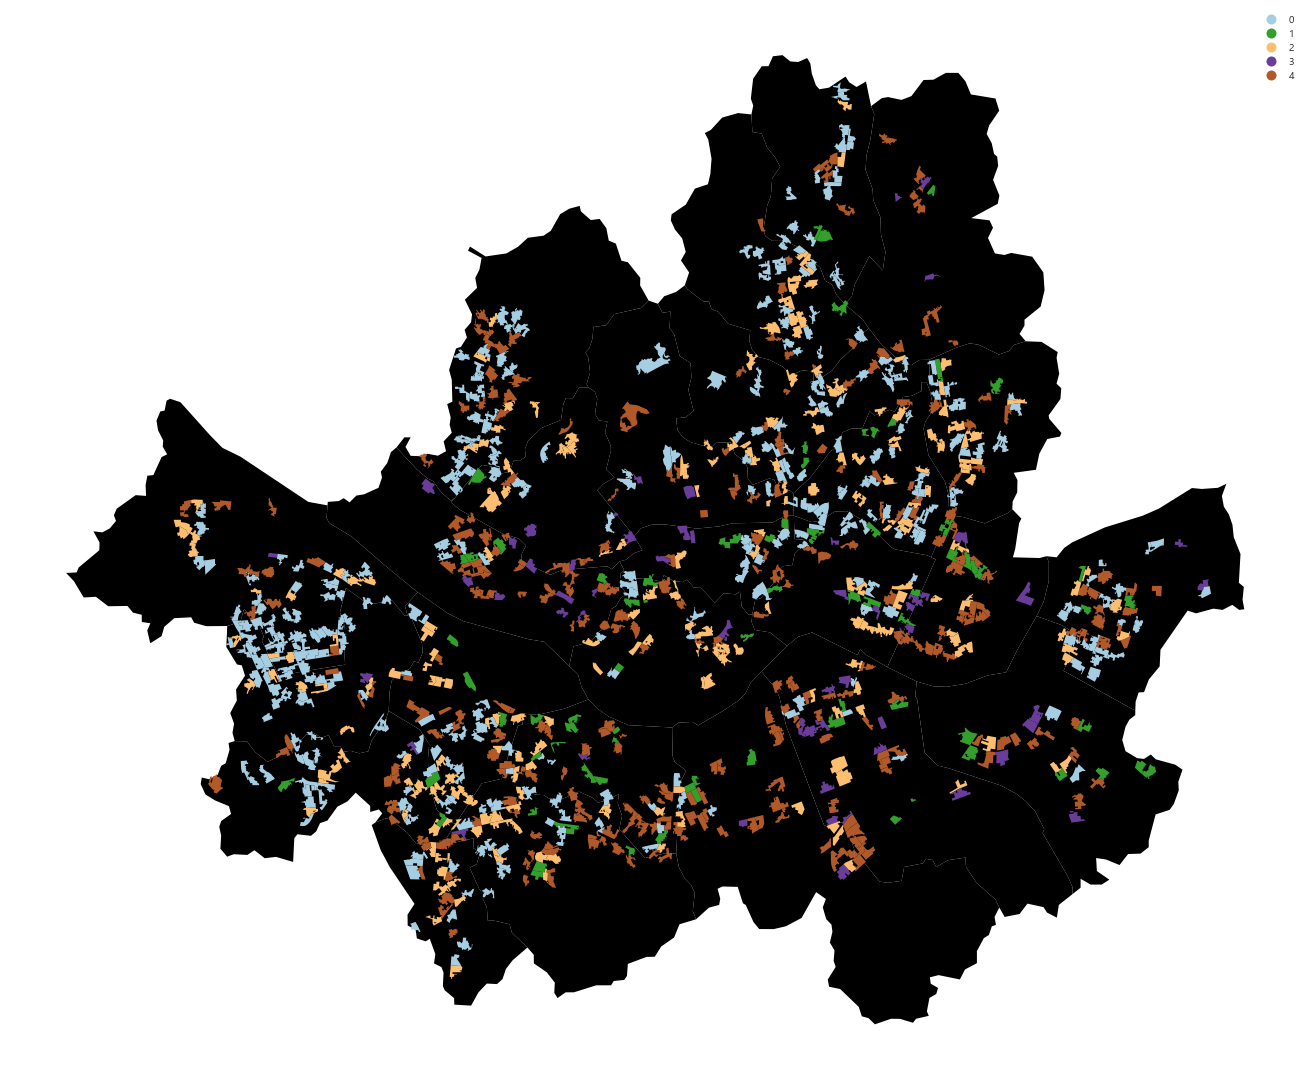

In [22]:
fig = plt.figure( figsize=(18, 15))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
seoul_lay.plot(ax = ax, color = '#000000')
gdf.plot(ax = ax, column='cluster_y', legend=True, cmap='Paired');

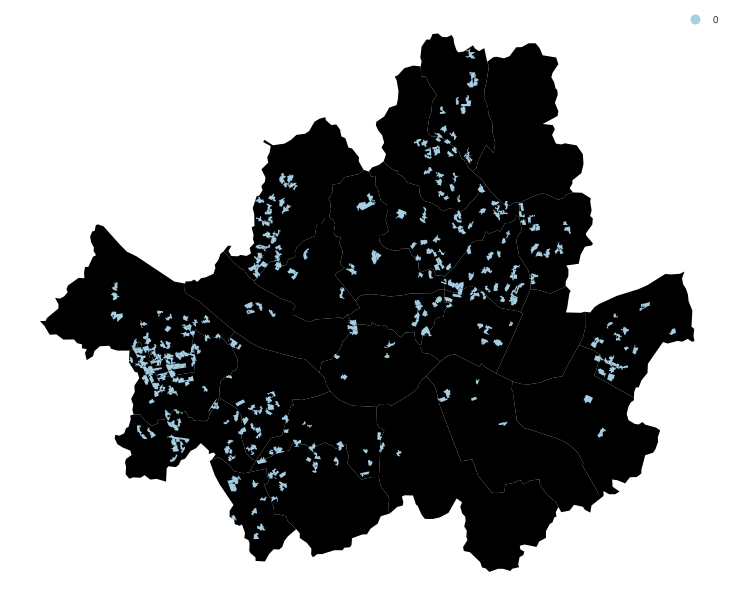

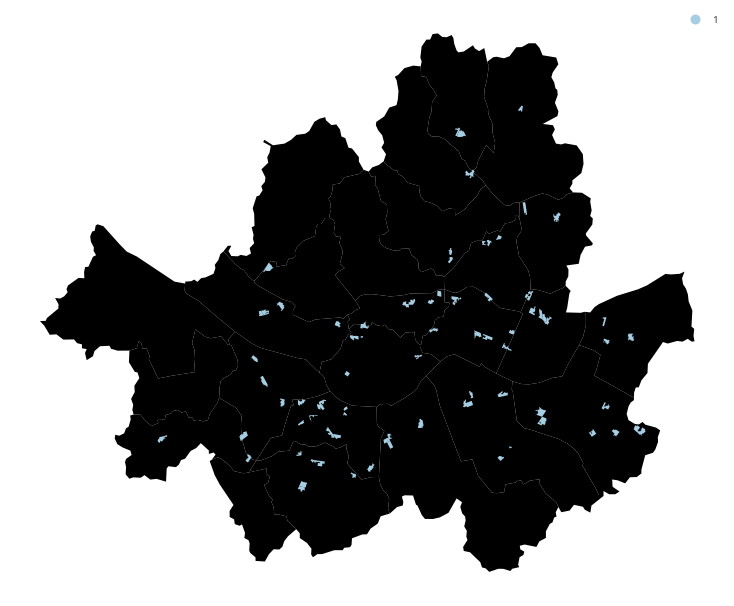

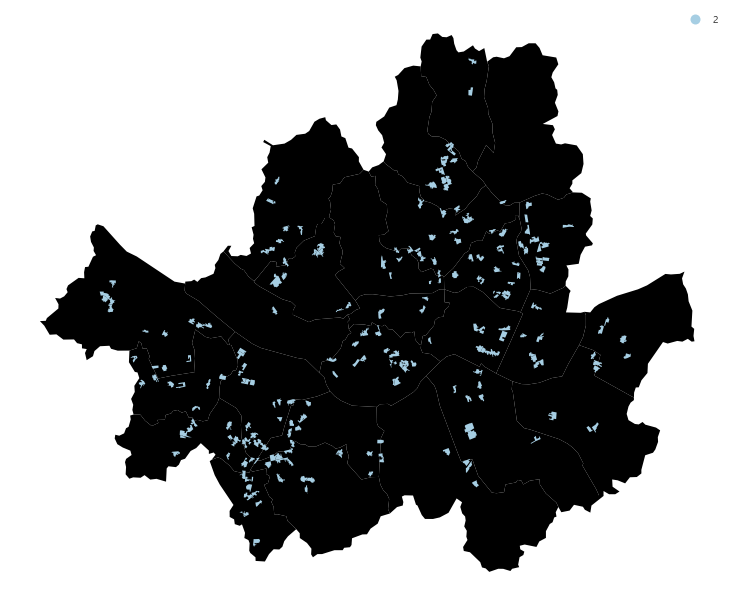

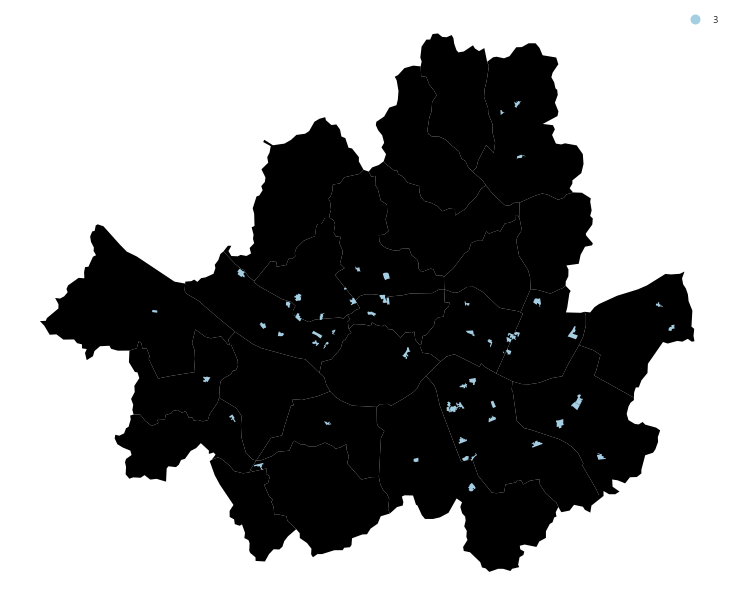

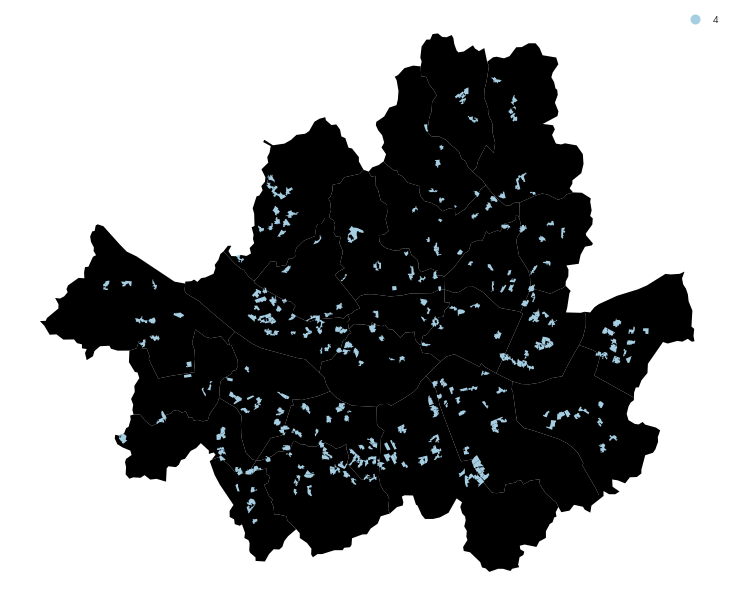

In [70]:
show_part = df_result.copy()

def select_cluster(X, cluster):
    if X == cluster:
        return cluster
    else:
        return np.nan
    
for i in range(0, 5):
    show_part[str(i)] = show_part['cluster_y'].apply( lambda x: x if x==str(i) else np.nan )

gdf = gpd.GeoDataFrame(show_part, geometry='geometry')

for i in range(0, 5):
    fig = plt.figure( figsize=(10, 10) )
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    seoul_lay.plot(ax = ax, color = '#000000')
    gdf.plot(ax = ax, column=str(i), legend=True, cmap='Paired')


# 데이터 저장

In [23]:
gdf.rename(columns={'TRDAR_CD':'상권_코드', 'TRDAR_CD_N':'상권_도로_명'}, inplace=True)
gdf.head()

,i1_ind1,i2_ind1,i3_ind1,cluster_y,TRDAR_SE_C,TRDAR_SE_1,상권_코드,상권_도로_명,XCNTS_VALU,YDNTS_VALU,SIGNGU_CD,ADSTRD_CD,STDR_YM_CD,area,perimeter,x,y,geometry
0,0.11,0.37,0.33,2,A,골목상권,1000001,계동길,198799,453610,11110,11110600,201810,125350.78,2312.70,126.99,37.58,"MULTIPOLYGON (((126.98591 37.58549, 126.98626 ..."
1,0.16,0.34,0.24,2,A,골목상권,1000002,난계로27길,201996,452630,11110,11110710,201810,31696.16,959.67,127.02,37.57,"MULTIPOLYGON (((127.02335 37.57240, 127.02335 ..."
2,0.07,0.42,0.61,3,A,골목상권,1000003,돈화문로11가길,198977,452902,11110,11110615,201810,113805.69,1346.57,126.99,37.58,"MULTIPOLYGON (((126.98909 37.57418, 126.98771 ..."
3,0.25,0.34,0.39,2,A,골목상권,1000004,명륜길,199558,454351,11110,11110650,201810,44023.15,1384.35,126.99,37.59,"MULTIPOLYGON (((126.99403 37.59000, 126.99419 ..."
4,0.07,0.15,0.59,4,A,골목상권,1000005,백석동길,197153,455283,11110,11110550,201810,367064.09,4821.13,126.97,37.60,"MULTIPOLYGON (((126.97014 37.59995, 126.97301 ..."


In [24]:
path = './data/cluster/cluster_csv.csv'
gdf.to_csv(path, index=False)
pd.read_csv(path).head()

,i1_ind1,i2_ind1,i3_ind1,cluster_y,TRDAR_SE_C,TRDAR_SE_1,상권_코드,상권_도로_명,XCNTS_VALU,YDNTS_VALU,SIGNGU_CD,ADSTRD_CD,STDR_YM_CD,area,perimeter,x,y,geometry
0,0.11,0.37,0.33,2,A,골목상권,1000001,계동길,198799,453610,11110,11110600,201810,125350.78,2312.70,126.99,37.58,MULTIPOLYGON (((126.9859074256922 37.585493266...
1,0.16,0.34,0.24,2,A,골목상권,1000002,난계로27길,201996,452630,11110,11110710,201810,31696.16,959.67,127.02,37.57,MULTIPOLYGON (((127.023348993374 37.5724010758...
2,0.07,0.42,0.61,3,A,골목상권,1000003,돈화문로11가길,198977,452902,11110,11110615,201810,113805.69,1346.57,126.99,37.58,MULTIPOLYGON (((126.9890874689013 37.574182075...
3,0.25,0.34,0.39,2,A,골목상권,1000004,명륜길,199558,454351,11110,11110650,201810,44023.15,1384.35,126.99,37.59,MULTIPOLYGON (((126.9940294980999 37.589996937...
4,0.07,0.15,0.59,4,A,골목상권,1000005,백석동길,197153,455283,11110,11110550,201810,367064.09,4821.13,126.97,37.60,MULTIPOLYGON (((126.9701361548509 37.599947555...
